In [2]:
%%capture
%pip install requests
%pip install pandas
%pip install matplotlib

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

page_size = 1000 # max page size

In [30]:
maker_subgraph_url = 'https://api.thegraph.com/subgraphs/name/protofire/maker-protocol'




with open("getMakerVault.graphql", "r") as file:
    get_maker_vault_query = file.read()

# Define the DataFrame columns
df_columns = ['block_number', 'debt', 'collateral',  'price_value']
# dataframe = pd.DataFrame(columns=df_columns)
data_rows = []

days = 365
for i in range(days):
    block_number = 17015885 + i * 300 * 24

    # Variables to be passed to the query
    variables = {
        "vaultId": "0x655e761c941cdbae43514f65e57865f9bc3f54ab-ETH-A",
        "blockNumber": block_number
    }


    r = requests.post(maker_subgraph_url, json={'query': get_maker_vault_query, 'variables': variables})
    vault_data = r.json()

    # Check if the response contains data
    if 'data' in vault_data and 'vaults' in vault_data['data'] and len(vault_data['data']['vaults']) > 0:
        # Extract the data for the DataFrame
        for vault in vault_data['data']['vaults']:
            row = {
                'block_number': block_number,
                'debt': vault['debt'],
                'collateral': vault['collateral'],
                'price_value': vault['collateralType']['price']['value'],
            }
            data_rows.append(row)

df = pd.DataFrame(data_rows, columns=df_columns)
df.head()



,block_number,debt,collateral,price_value
0,17015885,235678.158116256909875389,210.121537695107541865,1854.15908985
1,17023085,254069.757671027587628657,220.440035711268012455,1936
2,17030285,254069.757671027587628657,220.440035711268012455,1870
3,17037485,254069.757671027587628657,220.440035711268012455,1916
4,17044685,272459.524312413603895068,230.404101200925756756,2124.51686027


In [62]:
df['price_value'] = df['price_value'].astype(float)
df['return'] = df['price_value'].pct_change()
df['collateral'] = df['collateral'].astype(float)
df['debt'] = df['debt'].astype(float)
df['total_collateral'] = df['collateral'].astype(float) * df['price_value']
df['health_factor'] = df['total_collateral'] / df['debt'].astype(float)


df.head()



,block_number,debt,collateral,price_value,return,total_collateral,health_factor
0,17015885,235678.158116,210.121538,1854.15909,NaN,389598.759091,1.653097
1,17023085,254069.757671,220.440036,1936.00000,0.044139,426771.909137,1.679743
2,17030285,254069.757671,220.440036,1870.00000,-0.034091,412222.866780,1.622479
3,17037485,254069.757671,220.440036,1916.00000,0.024599,422363.108423,1.662390
4,17044685,272459.524312,230.404101,2124.51686,0.108829,489497.397677,1.796588


b_0:  1.411543922629344
b_1:  0.0001387365928979748


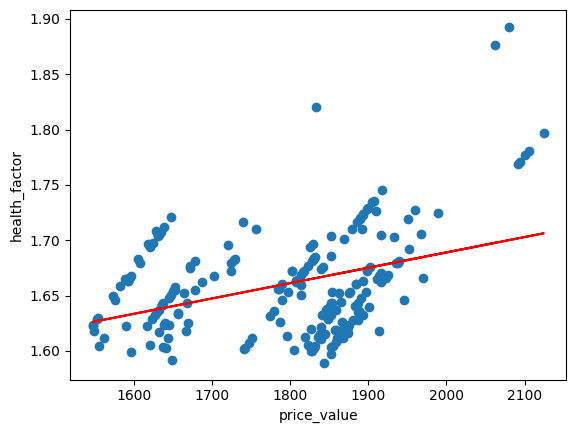

In [63]:
from linear_regression import linear_regression

b_0, b_1 = linear_regression(df['price_value'], df['health_factor'])

print("b_0: ", b_0)
print("b_1: ", b_1)

# plot the scatterplot and the regression line
plt.scatter(df['price_value'], df['health_factor'])
plt.xlabel('price_value')
plt.ylabel('health_factor')
plt.plot(df['price_value'], b_0 + b_1 * df['price_value'], color='red')
plt.show()


In [75]:
import random

liquidation_ratio = 1.63
liquidation_penalty = 0.13

def liquidationCheck(collateral, debt, health_factor, clearing_price):
    if health_factor < liquidation_ratio:
        return (True, collateral * clearing_price * (1 - liquidation_penalty) - debt)
    else:
        return (False, 0)



def monte_carlo_var(df, num_simulations, holding_period, alpha, starting_price):
    mean_return = df['return'].mean()
    std_return =df['return'].std()

    liquidation_events = 0
    losses = 0
    simulated_end_price = []
    for _ in range(num_simulations):
        curr_returns = 1 
        for _ in range(holding_period):
            curr_returns *= 1 + random.gauss(mean_return, std_return) 
            curr_price = starting_price * curr_returns
            h_f = b_0 + b_1 * curr_price

            (got_liquidated, loss) = liquidationCheck(
                df['collateral'].tail(1).item(), df['debt'].tail(1).item(), h_f, curr_price
            )
            if got_liquidated:
                
                losses += loss
                liquidation_events += 1
                break


    liquidation_probability = liquidation_events / num_simulations
    print("Expected loss: ", losses / num_simulations)
    return liquidation_probability


# params
num_simulations = 10000
holding_period = 1
alpha = 0.01

# run monte carlo simulation
monte_carlo_var = monte_carlo_var(
    df, num_simulations, holding_period, alpha, 1650
)
print("Liquidation probability: ", monte_carlo_var)

Expected loss:  886.7168872067159
Liquidation probability:  0.0246
